# Projection plots for CERN HL YR

David Straub, 2018

In [1]:
import flavio
from wilson import Wilson
flavio.__version__

'1.0'

NP scenarios

In [2]:
w1 = Wilson({'C9_bsmumu': -1}, scale=4.8, eft='WET', basis='flavio')
w2 = Wilson({'C9_bsmumu': -1, 'C9p_bsmumu': 1}, scale=4.8, eft='WET', basis='flavio')

Observables

In [4]:
obs = [
    ('<Rmue>(B+->Kll)', 1, 6),
    ('<Rmue>(B0->K*ll)', 1.1, 6),
    ('<Rmue>(Bs->phill)', 1.1, 6),
]
obs_belle = [
    ('<Rmue>(B+->Kll)', 1, 6),
    ('<Rmue>(B0->K*ll)', 1.1, 6),
]

Central NP predictions

In [5]:
for o in obs:
    print(o, flavio.np_prediction(o[0], w1, *o[1:]), flavio.np_prediction(o[0], w2, *o[1:]))

('<Rmue>(B+->Kll)', 1, 6) 0.7925941555619858 1.0000969543775167
('<Rmue>(B0->K*ll)', 1.1, 6) 0.8467641498941252 0.7449179797960322
('<Rmue>(Bs->phill)', 1.1, 6) 0.8393803172768358 0.7291375811418493


Load measurements (projections)

In [6]:
proj = flavio.measurements.read_file('./yr_projections.yaml')

In [7]:
from flavio.statistics.likelihood import FastLikelihood
import flavio.plots as fpl

Compute SM uncertainties (even if negligible)

In [8]:
%%time
smcov = flavio.sm_covariance(obs_list=obs, N=100, threads=4)

CPU times: user 260 ms, sys: 55.3 ms, total: 315 ms
Wall time: 7.44 s


Initialize likelihoods

In [9]:
%%time
llh = {}
for meas in proj:
    try:
        observables = obs
        llh[meas] = FastLikelihood(meas, observables=observables, include_measurements=[meas])
    except AssertionError:
        observables = obs_belle
        llh[meas] = FastLikelihood(meas, observables=observables, include_measurements=[meas])
    smcov_dict = dict(covariance=smcov, observables=observables)
    llh[meas].sm_covariance.load_dict(smcov_dict)
    llh[meas].make_measurement()

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 161 ms


In [10]:
par = flavio.default_parameters.get_central_all()

Compute plot data

In [11]:
%%time
pdat = {}
for meas in proj:
    
    def log_likelihood(x):
        C9, C9p = x
        w = Wilson({'C9_bsmumu': C9, 'C9p_bsmumu': C9p}, scale=4.8, eft='WET', basis='flavio')
        return llh[meas].log_likelihood(par, w)
    
    pdat[meas] = fpl.likelihood_contour_data(log_likelihood, -2, 1, -1.5, 1.5, steps=40, threads=4, n_sigma=(1, 2, 3, 4, 5))

CPU times: user 876 ms, sys: 577 ms, total: 1.45 s
Wall time: 10min 11s


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Hack to change number of sigma contours

In [14]:
def makesigma(pdat, levels):
    _pdat = pdat.copy()
    _pdat['levels'] = [0] + [flavio.statistics.functions.delta_chi2(n, dof=2) for n in levels]
    return _pdat

Save data file for later

In [17]:
import pickle
with open('pdat_YR_C9_C9p.p', 'wb') as f:
    pickle.dump(pdat, f)

Plot

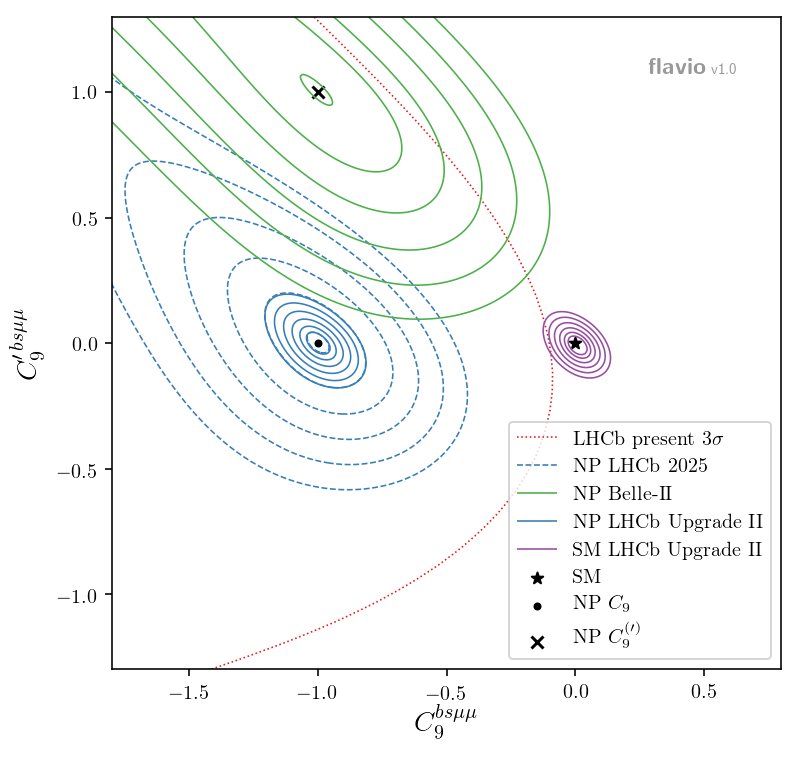

In [18]:
plt.figure(figsize=(6, 6))
fpl.contour(**makesigma(pdat['YR projection Current LHCb'], (3,)), label=r'LHCb present $3\sigma$', col=0, filled=False, contour_args=dict(linestyles=':'))
fpl.contour(**makesigma(pdat['YR projection NP LHCb 2025'], (1,2,3,4,5)), label='NP LHCb 2025', col=1, filled=False, interpolation_factor=10, contour_args=dict(linestyles='--'))
fpl.contour(**makesigma(pdat['YR projection NP Belle-II'], (1,2,3,4,5)), label='NP Belle-II', col=2, filled=False, interpolation_factor=10)
fpl.contour(**makesigma(pdat['YR projection NP LHCb Upgrade II'], (1,2,3,4,5)), label='NP LHCb Upgrade II', col=1, interpolation_factor=10, filled=False)
fpl.contour(**makesigma(pdat['YR projection SM LHCb Upgrade II'], (1,2,3,4,5)), label='SM LHCb Upgrade II', col=3, interpolation_factor=10, filled=False)
plt.xlabel(r'$C_9^{bs\mu\mu}$')
plt.ylabel(r'$C_9^{\prime\,bs\mu\mu}$')
plt.scatter([0], [0], marker='*', label='SM', c='k')
plt.scatter([-1], [0], marker='.', label='NP $C_9$', c='k')
plt.scatter([-1], [1], marker='x', label=r'NP $C_9^{(\prime)}$', c='k')
plt.xlim([-1.8, 0.8])
plt.ylim([-1.3, 1.3])
plt.legend(loc='lower right');
fpl.flavio_branding(version=True)
plt.savefig('YR_C9_C9p.pdf', bbox_inches='tight')